# Training Deep Neural Networks

## Importing Libraries

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## The Vanishing / Exploding Gradients Problem

- In most cases, during back propagation, gradients keep reducing as the algorithm progresses to lower layers of the NN. This leaves the lower layer connection weights virtually unchanged and training fails to converge. This is known as the **Vanishing Gradients** problem.
- Conversely, the opposite can happen and the gradients can keep growing during back-prop. causing the algorithm to diverge. This is known as the **Exploding Gradients** problem, which is known to surface in RNNs.
- Bengio and Glorot (2010) found that the combination of logistic sigmoid activation and weight initialization (using a normal distribution, with mean=0 and std=1) caused the variance of the outputs of each layers was much greater than the variance of the inputs.
- The variance keeps increasing after each layer until the activation function saturates at the top layers. The saturation is further worsened by the fact that the logistic function has a mean of 0.5 and not 0. (tanh has mean of 0 and is a slight improvement over the sigmoid function.)

In [2]:
# Creating a visualization of the Vanishing / Exploding Gradients problem
def logit(z):
    return 1 / (1 + np.exp(-z))

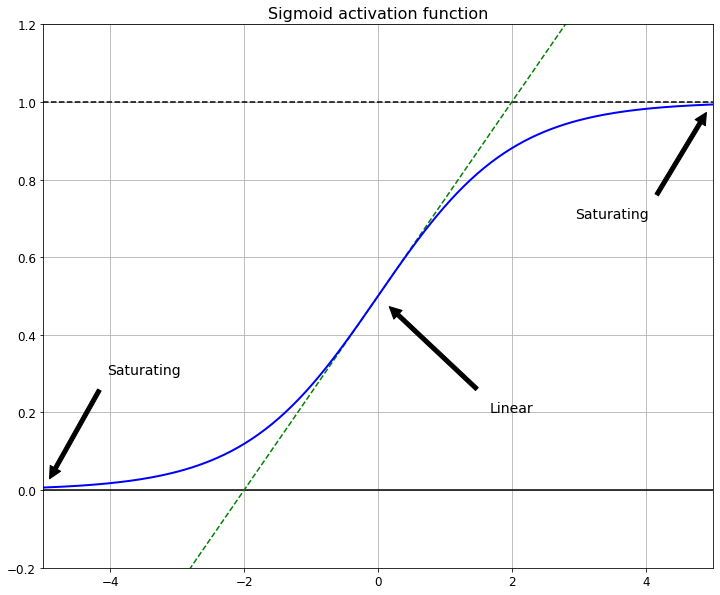

In [3]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(12,10))
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, -0.2], "k-")
plt.plot([-5, 5], [-3/4, 7/4], "g--")
plt.plot(z, logit(z), "b-", linewidth=2)

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=16)
plt.axis([-5, 5, -0.2, 1.2])
plt.show();

## Glorot/Xavier and He Initialization

- Connection weights of each layer must be initialized randomly in order to ensure that the variance of the output layers is equal to variance of inputs.
- Gradients must also have equal variance before and after flowing through a layer in the reverse direction.
- Details are available in the following [paper](https://calibre-internal.invalid/OEBPS/ch11.html#idm46028932885000).

In [4]:
# Getting all initializers in Keras
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

**Let's also get the list of initializers in Pytorch**

In [5]:
import torch

In [6]:
[name for name in dir(torch.nn.init) if not (name.startswith("_") or name.endswith("_"))]

['calculate_gain',
 'constant',
 'dirac',
 'division',
 'eye',
 'kaiming_normal',
 'kaiming_uniform',
 'math',
 'normal',
 'orthogonal',
 'sparse',
 'torch',
 'uniform',
 'warnings',
 'xavier_normal',
 'xavier_uniform']

## Non-saturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

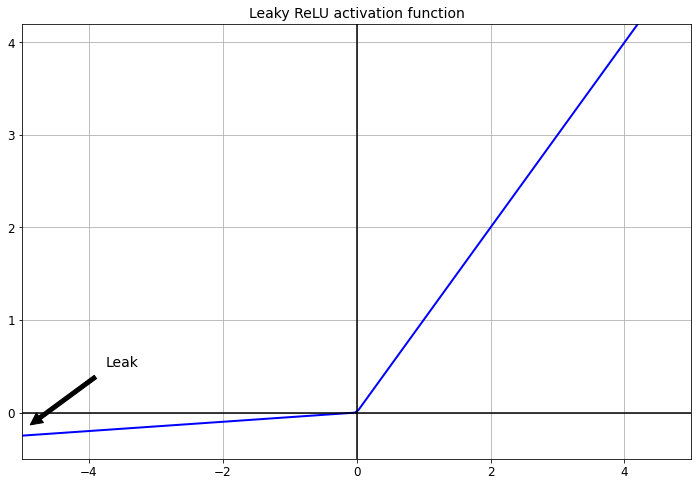

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [9]:
# This is a list of keras activations
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
# This is a list of keras relu layers
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Training a neural net on the Fashion MNIST dataset using leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [12]:
# Dividing the images by 255.0 to normalize them i.e. rescaling them from 0-255 to 0-1
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"), # HE normalization is named after the author of the original paper.
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
# Model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
__________________________________________________

In [15]:
# Compiling the model and specifying a loss function, SGD optimizer
# and evaluation metrics
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [16]:
# Training the model
history = model.fit(X_train, y_train, epochs=15,
               validation_data = (X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 2s 44us/sample - loss: 1.2806 - accuracy: 0.6250 - val_loss: 0.8882 - val_accuracy: 0.7152
Epoch 2/15
55000/55000 [==============================] - 2s 39us/sample - loss: 0.7954 - accuracy: 0.7374 - val_loss: 0.7134 - val_accuracy: 0.7648
Epoch 3/15
55000/55000 [==============================] - 2s 37us/sample - loss: 0.6816 - accuracy: 0.7727 - val_loss: 0.6356 - val_accuracy: 0.7882
Epoch 4/15
55000/55000 [==============================] - 2s 37us/sample - loss: 0.6215 - accuracy: 0.7935 - val_loss: 0.5922 - val_accuracy: 0.8012
Epoch 5/15
55000/55000 [==============================] - 2s 37us/sample - loss: 0.5830 - accuracy: 0.8081 - val_loss: 0.5596 - val_accuracy: 0.8172
Epoch 6/15
55000/55000 [==============================] - 2s 37us/sample - loss: 0.5553 - accuracy: 0.8155 - val_loss: 0.5338 - val_accuracy: 0.8238
Epoch 7/15
55000/55000 [==============================] -

**Trying PReLU instead of ReLU**

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
# Training the model, now with PReLU
history = model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=keras.optimizers.SGD(lr=1e-3),
                        metrics=["accuracy"])

In [19]:
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 2s 44us/sample - loss: 1.3470 - accuracy: 0.6225 - val_loss: 0.9268 - val_accuracy: 0.7200
Epoch 2/15
55000/55000 [==============================] - 2s 38us/sample - loss: 0.8209 - accuracy: 0.7357 - val_loss: 0.7322 - val_accuracy: 0.7640
Epoch 3/15
55000/55000 [==============================] - 2s 40us/sample - loss: 0.6972 - accuracy: 0.7697 - val_loss: 0.6494 - val_accuracy: 0.7866
Epoch 4/15
55000/55000 [==============================] - 2s 41us/sample - loss: 0.6332 - accuracy: 0.7904 - val_loss: 0.6027 - val_accuracy: 0.8024
Epoch 5/15
55000/55000 [==============================] - 2s 41us/sample - loss: 0.5918 - accuracy: 0.8050 - val_loss: 0.5675 - val_accuracy: 0.8140
Epoch 6/15
55000/55000 [==============================] - 2s 42us/sample - loss: 0.5619 - accuracy: 0.8141 - val_loss: 0.5393 - val_accuracy: 0.8252
Epoch 7/15
55000/55000 [==============================] -

### ELU

In [20]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

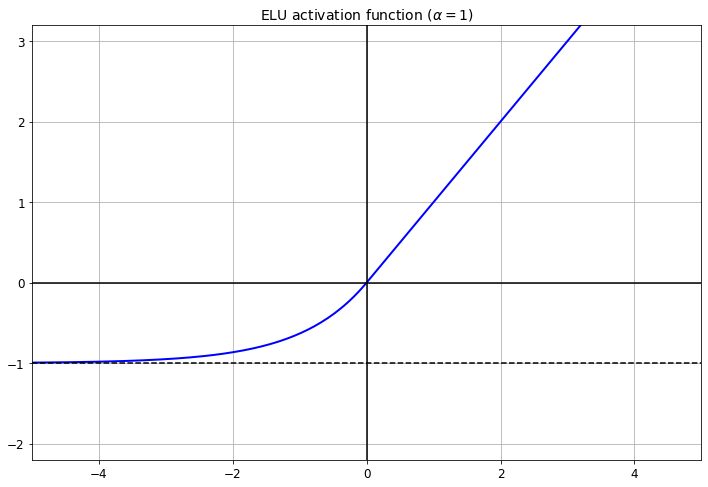

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()



The text states that the implementation of ELU in TensorFlow is trivial, simply specify the activation function when building each layer:

In [22]:
keras.layers.Dense(10, activation="elu")

### SELU

According to A. Geron, the SELU function is, at best, an experimental activation function:

_"This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions."_

In [23]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [24]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

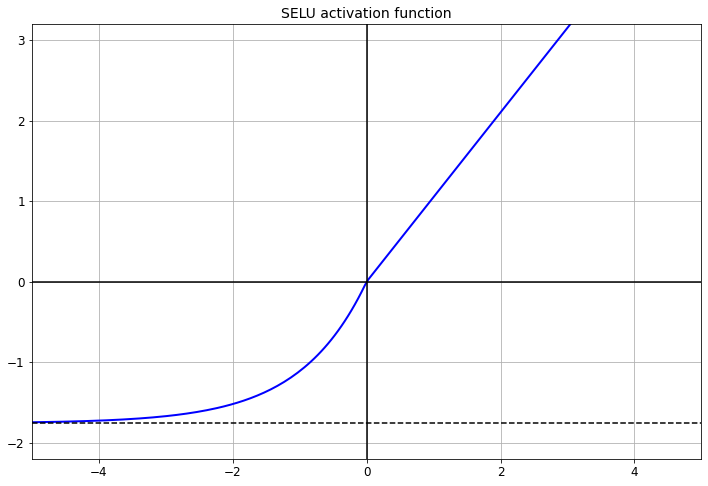

In [25]:
plt.figure(figsize=(12,8))
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

Furthermore, the author also states:

_"By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem"_

In [26]:
np.random.seed(42)

Z = np.random.normal(size=(500, 100)) # standardized inputs

In [27]:
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean{:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean-0.00, std deviation 1.00
Layer 100: mean0.02, std deviation 0.96
Layer 200: mean0.01, std deviation 0.90
Layer 300: mean-0.02, std deviation 0.92
Layer 400: mean0.05, std deviation 0.89
Layer 500: mean0.01, std deviation 0.93
Layer 600: mean0.02, std deviation 0.92
Layer 700: mean-0.02, std deviation 0.90
Layer 800: mean0.05, std deviation 0.83
Layer 900: mean0.02, std deviation 1.00


**To implement SELU, let's train a 100 layer NN on the same dataset as before. However, due to the large size of the NN, we'll loop through its creation:**

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential()

In [30]:
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))

for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 100)              

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

**Prior to training the network, we have to scale the inputs to mean 0 and std. 1**

In [33]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data = (X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 25s 458us/sample - loss: 1.5288 - accuracy: 0.3919 - val_loss: 1.1271 - val_accuracy: 0.5696
Epoch 2/5
55000/55000 [==============================] - 20s 371us/sample - loss: 0.9810 - accuracy: 0.6161 - val_loss: 0.8291 - val_accuracy: 0.6870
Epoch 3/5
55000/55000 [==============================] - 20s 369us/sample - loss: 0.8295 - accuracy: 0.6776 - val_loss: 0.7041 - val_accuracy: 0.7306
Epoch 4/5
55000/55000 [==============================] - 21s 376us/sample - loss: 0.7604 - accuracy: 0.7057 - val_loss: 0.6454 - val_accuracy: 0.7546
Epoch 5/5
55000/55000 [==============================] - 21s 378us/sample - loss: 0.6655 - accuracy: 0.7509 - val_loss: 0.6346 - val_accuracy: 0.7734


## Batch Normalization

Batch Norm lets the model learn the optimal scale and mean of each of the layer's inputs. In lots of cases adding a BN layer as the very first layer of the NN frees us from standardizing the training set (e.g. using a StandardScaler); BN does it for us, looking at one batch at a time.

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_108 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_109 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_110 (Dense)            (None, 10)               

Each BN layer adds four parameters per input: $\gamma, \beta, \mu$ and $\sigma$, where the last two parameters are moving averages and are not affected by back-propagation. Keras calls these non-trainable.

In [37]:
# Observing the parameters of the first BN layer.
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [39]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.8767 - accuracy: 0.7137 - val_loss: 0.5531 - val_accuracy: 0.8206
Epoch 2/10
55000/55000 [==============================] - 3s 61us/sample - loss: 0.5755 - accuracy: 0.8019 - val_loss: 0.4758 - val_accuracy: 0.8458
Epoch 3/10
55000/55000 [==============================] - 3s 62us/sample - loss: 0.5154 - accuracy: 0.8212 - val_loss: 0.4397 - val_accuracy: 0.8538
Epoch 4/10
55000/55000 [==============================] - 3s 60us/sample - loss: 0.4843 - accuracy: 0.8311 - val_loss: 0.4162 - val_accuracy: 0.8592
Epoch 5/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.4561 - accuracy: 0.8424 - val_loss: 0.4003 - val_accuracy: 0.8652
Epoch 6/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.4400 - accuracy: 0.8468 - val_loss: 0.3884 - val_accuracy: 0.8694
Epoch 7/10
55000/55000 [==============================] -

The authors of the BN paper argued in favour of adding the BN layers before the activation functions rather than after, however, one can always experiment with different models to observe which approach works best with different types of datasets. 

The layers before BN layers don't need to have bias terms.

In [40]:
# Removing bias terms
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [41]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [42]:
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 72us/sample - loss: 1.0323 - accuracy: 0.6754 - val_loss: 0.6734 - val_accuracy: 0.7842
Epoch 2/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.6778 - accuracy: 0.7815 - val_loss: 0.5572 - val_accuracy: 0.8200
Epoch 3/10
55000/55000 [==============================] - 3s 60us/sample - loss: 0.5924 - accuracy: 0.8050 - val_loss: 0.5003 - val_accuracy: 0.8346
Epoch 4/10
55000/55000 [==============================] - 3s 62us/sample - loss: 0.5449 - accuracy: 0.8168 - val_loss: 0.4668 - val_accuracy: 0.8434
Epoch 5/10
55000/55000 [==============================] - 3s 62us/sample - loss: 0.5117 - accuracy: 0.8267 - val_loss: 0.4432 - val_accuracy: 0.8514
Epoch 6/10
55000/55000 [==============================] - 3s 61us/sample - loss: 0.4886 - accuracy: 0.8353 - val_loss: 0.4278 - val_accuracy: 0.8548
Epoch 7/10
55000/55000 [==============================] -

## Reusing Pretrained Layers  -  aka Transfer Learning

**`Pro Tip`** The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, try keeping all the hidden layers and just replace the output layer.

Try freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won’t modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.

In [43]:
# Creating two training sets, on which we will train two models.
# Set A has 8 classes and we will try to reuse it to tackle set B which is binary
# Since we are using a Dense net, the only patterns that occur at the same locations can be reused.
def split_data(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    
    y_A[y_A > 6] -= 2 # class indices 7,8,9 should be shifted to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype('float32') #binary calssification task: is it a shirt (keeping class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

In [44]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_data(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_data(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_data(X_test, y_test)

In [45]:
X_train_B = X_train_B[:200] #Limiting the size of dataset B
y_train_B = y_train_B[:200]

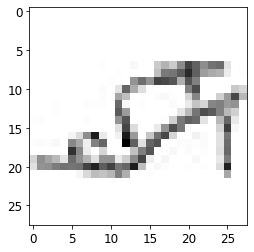

In [46]:
plt.imshow(X_train_B[185], cmap='binary');

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
# Observing classes
y_train_A[:20]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3],
      dtype=uint8)

In [50]:
y_train_B[:20]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model_A = keras.models.Sequential()

model_A.add(keras.layers.Flatten(input_shape=[28, 28]))

for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
    
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_111 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [54]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [55]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 3s 59us/sample - loss: 0.5909 - accuracy: 0.8100 - val_loss: 0.3772 - val_accuracy: 0.8712
Epoch 2/20
43986/43986 [==============================] - 2s 51us/sample - loss: 0.3520 - accuracy: 0.8793 - val_loss: 0.3393 - val_accuracy: 0.8782
Epoch 3/20
43986/43986 [==============================] - 2s 53us/sample - loss: 0.3167 - accuracy: 0.8889 - val_loss: 0.3016 - val_accuracy: 0.8961
Epoch 4/20
43986/43986 [==============================] - 2s 56us/sample - loss: 0.2969 - accuracy: 0.8967 - val_loss: 0.2858 - val_accuracy: 0.9031
Epoch 5/20
43986/43986 [==============================] - 2s 49us/sample - loss: 0.2824 - accuracy: 0.9032 - val_loss: 0.2807 - val_accuracy: 0.9063
Epoch 6/20
43986/43986 [==============================] - 2s 51us/sample - loss: 0.2721 - accuracy: 0.9071 - val_loss: 0.2683 - val_accuracy: 0.9103
Epoch 7/20
43986/43986 [==============================] -

**In contrast CNNs are superior at handling transfer learning since learned patterns can be detected anywhere on the image.**

In [56]:
# Saving the first model for the purpose of transfer learning
model_A.save("model_A.h5")

In [57]:
# Training model_B
model_B = keras.models.Sequential()

model_B.add(keras.layers.Flatten(input_shape=[28, 28]))

for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))

model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [58]:
model_B.compile(loss="binary_crossentropy", 
                optimzer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [59]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 5ms/sample - loss: 0.8348 - accuracy: 0.6900 - val_loss: 0.0662 - val_accuracy: 0.9848
Epoch 2/20
200/200 [==============================] - 0s 270us/sample - loss: 0.0355 - accuracy: 0.9950 - val_loss: 0.0513 - val_accuracy: 0.9858
Epoch 3/20
200/200 [==============================] - 0s 261us/sample - loss: 0.0175 - accuracy: 0.9950 - val_loss: 0.7592 - val_accuracy: 0.6684
Epoch 4/20
200/200 [==============================] - 0s 270us/sample - loss: 0.0636 - accuracy: 0.9700 - val_loss: 0.0339 - val_accuracy: 0.9909
Epoch 5/20
200/200 [==============================] - 0s 277us/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0349 - val_accuracy: 0.9909
Epoch 6/20
200/200 [==============================] - 0s 265us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9909
Epoch 7/20
200/200 [==============================] - 0s 258us/sample - loss: 0.

In [60]:
# Loading model_A and creating a new model based on that model's layers
model_A = keras.models.load_model("model_A.h5")

In [61]:
# Reusing all the layers except for the output layer
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

**model_A and model_B_on_A now share some layers, training model_B_on_A will also effect model_A. To avoid this, we need to clone model_A before reusing its layers.**

_clone.model() clones the architecture and then we will copy the weights separately._

In [62]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

**We are ready to train model_B_on_A but since the new output layer was initialized randomly, it will make large errors and the large error gradients will throw off the reused weights.**

**To avoid this, one approach is to freeze the reused layers during the first epochs, thus allowing the new layer some time to learn reasonable weights.**

_Set every layer's trainable attribute to False and compile the model._

In [63]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

**Always compile the model after freezing or unfreezing the layers.**

In [64]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B)) # small number of epochs to learn the weights

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True # unfreezing
    
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 0s 2ms/sample - loss: 0.5807 - accuracy: 0.6550 - val_loss: 0.5813 - val_accuracy: 0.6450
Epoch 2/4
200/200 [==============================] - 0s 220us/sample - loss: 0.5425 - accuracy: 0.7050 - val_loss: 0.5468 - val_accuracy: 0.6815
Epoch 3/4
200/200 [==============================] - 0s 230us/sample - loss: 0.5086 - accuracy: 0.7200 - val_loss: 0.5164 - val_accuracy: 0.7140
Epoch 4/4
200/200 [==============================] - 0s 220us/sample - loss: 0.4784 - accuracy: 0.7600 - val_loss: 0.4870 - val_accuracy: 0.7292
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 1s 3ms/sample - loss: 0.3964 - accuracy: 0.8200 - val_loss: 0.3384 - val_accuracy: 0.8722
Epoch 2/16
200/200 [==============================] - 0s 241us/sample - loss: 0.2752 - accuracy: 0.9300 - val_loss: 0.2612 - val_accuracy: 0.9260
Epoch 3/16
200/200 [====================

In [65]:
model_B.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.028096967280805983, 0.9925]

In [66]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06899205070734024, 0.9925]

In [67]:
(100 - 99.25) / (100 - 99.80)

3.7499999999999467

The error rate has dropped by a factor of approximately 3.75!!

## Faster Optimizers

The various implementations of Optimization Algorithms in Keras are:

#### Momentum Optimization
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)


#### Nesterov Accelerated Gradient
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)


#### AdaGrad
optimizer = keras.optimizers.Adagrad(lr=0.001)


#### RMSProp
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)


#### Adam Optimization
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)


#### Adamax Optimization
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)


#### Nadam Optimization
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)


#### **A Note on Training Sparse Models**

- All of the above optimizers produce dense models i.e. most parameters are non-zero.
- In order to train a model which performs better at runtime / takes up lesser memory, then using a sparse model is another option.
- One way to achieve this train the model as usual and then set the tiny weights to zero. This may, however degrade the model's performance.
- A better method is to apply strong L1 regularization during training. This pushes the optimizer to zero out as many weights as it can (similar to Lasso Regression).

## Comparing Learning Rate Scheduling Techniques

### Power Scheduling

lr = lr0 / (1 + steps / s)**c

In [68]:
# Setting optimizer
# Here decay is the inverse of s i.e. number of steps it takes to divide the learning rate 
# by one more unit
optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-4)

In [69]:
# Creating a simply NN without BN
# Using selu activation for testing
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [70]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 51us/sample - loss: 0.7073 - accuracy: 0.7587 - val_loss: 0.5394 - val_accuracy: 0.8194
Epoch 2/25
55000/55000 [==============================] - 3s 47us/sample - loss: 0.5081 - accuracy: 0.8227 - val_loss: 0.4866 - val_accuracy: 0.8354
Epoch 3/25
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4693 - accuracy: 0.8369 - val_loss: 0.4604 - val_accuracy: 0.8434
Epoch 4/25
55000/55000 [==============================] - 2s 45us/sample - loss: 0.4486 - accuracy: 0.8433 - val_loss: 0.4462 - val_accuracy: 0.8510
Epoch 5/25
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4347 - accuracy: 0.8489 - val_loss: 0.4366 - val_accuracy: 0.8532
Epoch 6/25
55000/55000 [==============================] - 2s 42us/sample - loss: 0.4248 - accuracy: 0.8519 - val_loss: 0.4299 - val_accuracy: 0.8566
Epoch 7/25
55000/55000 [==============================] -

In [71]:
# Scheduler test
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)

scheduler = learning_rate / (1 + decay * epochs * n_steps_per_epoch) 

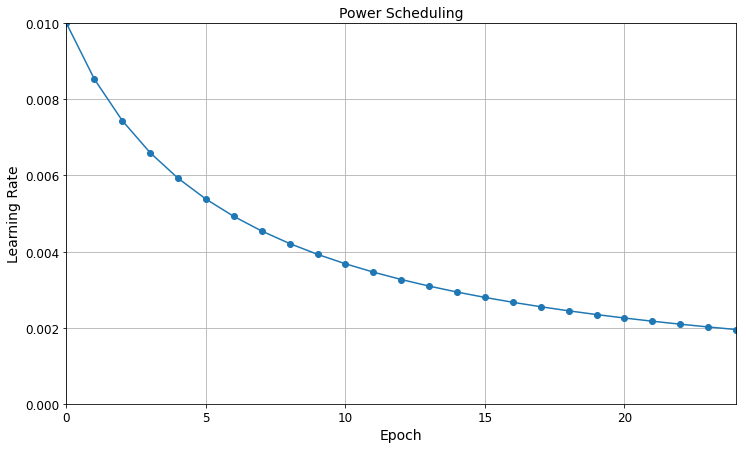

In [72]:
# plotting the learning rate curve
plt.figure(figsize=(12, 7))
plt.plot(epochs, scheduler, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

lr = lr0 * 0.1 **(epoch / s)

In [73]:
# Hardcoded LR
# Multiplying the previous LR by 0.1exp(1/20)
def  exponential_decay_fn(epoch):
    return 0.01 * 0.01**(epoch / 20)

In [74]:
# Semi Hardcoded where we have the option to set the LR
def exponential_decay(epoch, lr):
    return lr * 0.01**(epoch / 20)

In [75]:
# Non hardcoded LR
def exponential_decay(lr0, step):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / step)
    return exponential_decay_fn

In [76]:
exponential_decay_func = exponential_decay(lr0=0.01, step=20)

In [77]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

In [78]:
n_epochs = 25
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [79]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_func)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled , y_valid),
                   callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 95us/sample - loss: 0.8569 - accuracy: 0.7535 - val_loss: 0.9680 - val_accuracy: 0.7092
Epoch 2/25
55000/55000 [==============================] - 4s 80us/sample - loss: 0.7487 - accuracy: 0.7785 - val_loss: 0.7490 - val_accuracy: 0.7958
Epoch 3/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.6437 - accuracy: 0.8066 - val_loss: 0.6331 - val_accuracy: 0.8300
Epoch 4/25
55000/55000 [==============================] - 5s 85us/sample - loss: 0.5936 - accuracy: 0.8226 - val_loss: 0.6590 - val_accuracy: 0.8114
Epoch 5/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5542 - accuracy: 0.8354 - val_loss: 0.6462 - val_accuracy: 0.7702
Epoch 6/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5008 - accuracy: 0.8480 - val_loss: 0.5938 - val_accuracy: 0.8424
Epoch 7/25
55000/55000 [==============================] -

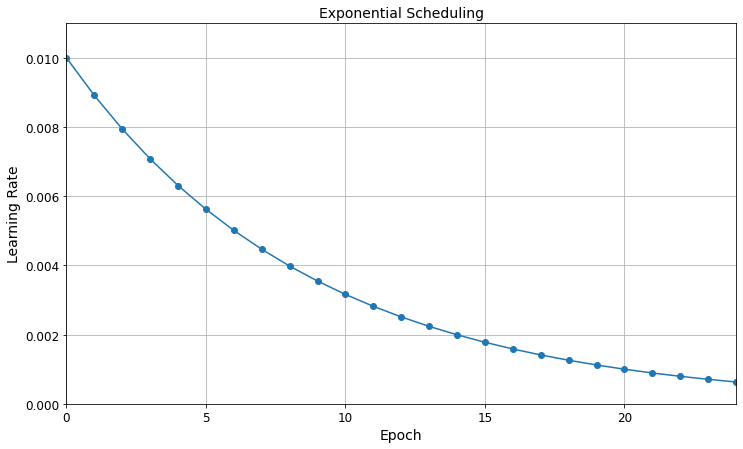

In [80]:
# Plotting
plt.figure(figsize=(12,7))
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**If we want to update our LR at each iteration rather than at each epoch, we must write our own callback class**

In [81]:
K = keras.backend

class Exponential_Decay(keras.callbacks.Callback):
    def __init__(self, s=40000): # Setting number of steps
        super().__init__()
        self.s = s
        
    def on_batch_begin(self, batch, logs=None):
        # The batch argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1/s))
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [82]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)

n_epochs = 25
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [83]:
s = 20 * len(X_train) // 32 # Number of steps in each epoch with a BS of 32

In [84]:
exp_decay = Exponential_Decay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 91us/sample - loss: 0.8077 - accuracy: 0.7649 - val_loss: 0.7334 - val_accuracy: 0.7880
Epoch 2/25
55000/55000 [==============================] - 5s 82us/sample - loss: 0.6417 - accuracy: 0.8021 - val_loss: 0.7800 - val_accuracy: 0.7436
Epoch 3/25
55000/55000 [==============================] - 5s 88us/sample - loss: 0.5733 - accuracy: 0.8241 - val_loss: 0.6145 - val_accuracy: 0.8394
Epoch 4/25
55000/55000 [==============================] - 5s 83us/sample - loss: 0.5135 - accuracy: 0.8414 - val_loss: 0.6197 - val_accuracy: 0.8368
Epoch 5/25
55000/55000 [==============================] - 5s 84us/sample - loss: 0.5193 - accuracy: 0.8423 - val_loss: 0.4839 - val_accuracy: 0.8448
Epoch 6/25
55000/55000 [==============================] - 5s 83us/sample - loss: 0.4223 - accuracy: 0.8634 - val_loss: 0.4747 - val_accuracy: 0.8644
Epoch 7/25
55000/55000 [==============================] -

In [85]:
# Values for plotting
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

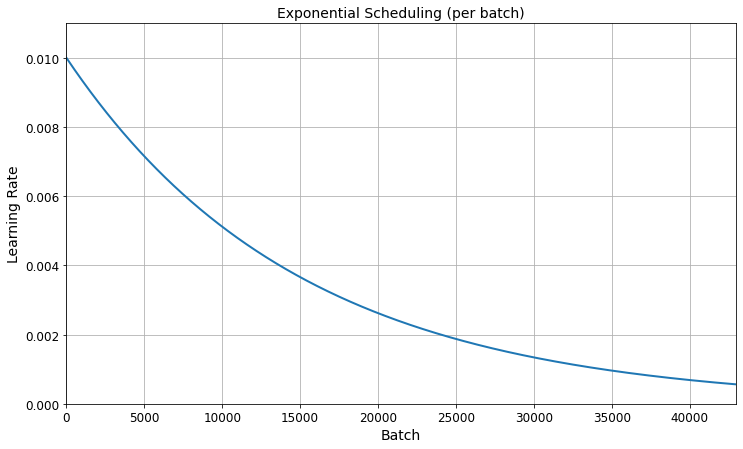

In [86]:
plt.figure(figsize=(12, 7))
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

Use a constant learning rate for a number of epochs and then a smaller learning rate for another number of epochs.

In [87]:
#  Simplistic PWC scheduling
def piecewise_constant_func(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [88]:
# User defined bounndaries
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    
    def piecewise_constant_func(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_func

piecewise_constant_func = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [89]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_func)

In [90]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [91]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid),
                   callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 81us/sample - loss: 0.8346 - accuracy: 0.7601 - val_loss: 0.8807 - val_accuracy: 0.7630
Epoch 2/25
55000/55000 [==============================] - 4s 72us/sample - loss: 0.9589 - accuracy: 0.7277 - val_loss: 1.5785 - val_accuracy: 0.5156
Epoch 3/25
55000/55000 [==============================] - 4s 73us/sample - loss: 1.1867 - accuracy: 0.6078 - val_loss: 1.0277 - val_accuracy: 0.5930
Epoch 4/25
55000/55000 [==============================] - 4s 77us/sample - loss: 1.1690 - accuracy: 0.6226 - val_loss: 1.3198 - val_accuracy: 0.5740
Epoch 5/25
55000/55000 [==============================] - 4s 76us/sample - loss: 1.1515 - accuracy: 0.5959 - val_loss: 1.1233 - val_accuracy: 0.5580
Epoch 6/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.8668 - accuracy: 0.6537 - val_loss: 0.9271 - val_accuracy: 0.6614
Epoch 7/25
55000/55000 [==============================] -

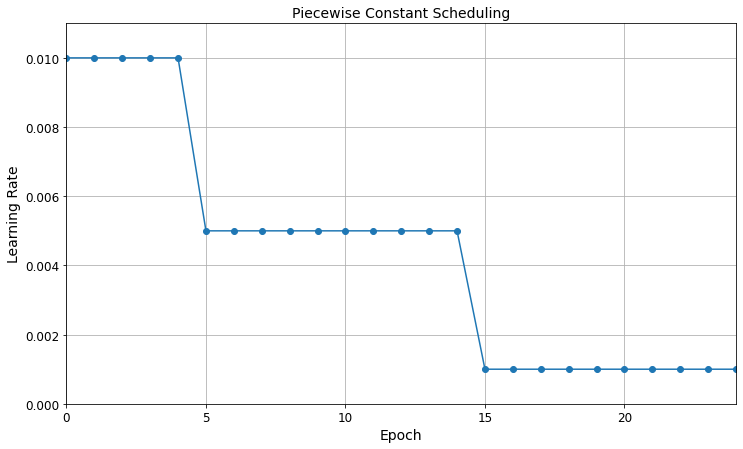

In [92]:
# Plotting the PWC LR policy
plt.figure(figsize=(12, 7))
plt.plot(history.epoch, [piecewise_constant_func(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

Measure the validation error every N step (similar to Early Stopping) and reduce the LR by a factor of $\lambda$ as the error stops dropping.

In [93]:
tf.random.set_seed(42)
np.random.seed(42)

In [94]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [95]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [96]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 54us/sample - loss: 0.6075 - accuracy: 0.8031 - val_loss: 0.5384 - val_accuracy: 0.8138
Epoch 2/25
55000/55000 [==============================] - 3s 46us/sample - loss: 0.5179 - accuracy: 0.8377 - val_loss: 0.5629 - val_accuracy: 0.8324
Epoch 3/25
55000/55000 [==============================] - 3s 50us/sample - loss: 0.5126 - accuracy: 0.8443 - val_loss: 0.5030 - val_accuracy: 0.8478
Epoch 4/25
55000/55000 [==============================] - 3s 51us/sample - loss: 0.5122 - accuracy: 0.8473 - val_loss: 0.4404 - val_accuracy: 0.8576
Epoch 5/25
55000/55000 [==============================] - 3s 47us/sample - loss: 0.5164 - accuracy: 0.8499 - val_loss: 0.5649 - val_accuracy: 0.8526
Epoch 6/25
55000/55000 [==============================] - 3s 47us/sample - loss: 0.5103 - accuracy: 0.8534 - val_loss: 0.5012 - val_accuracy: 0.8590
Epoch 7/25
55000/55000 [==============================] -

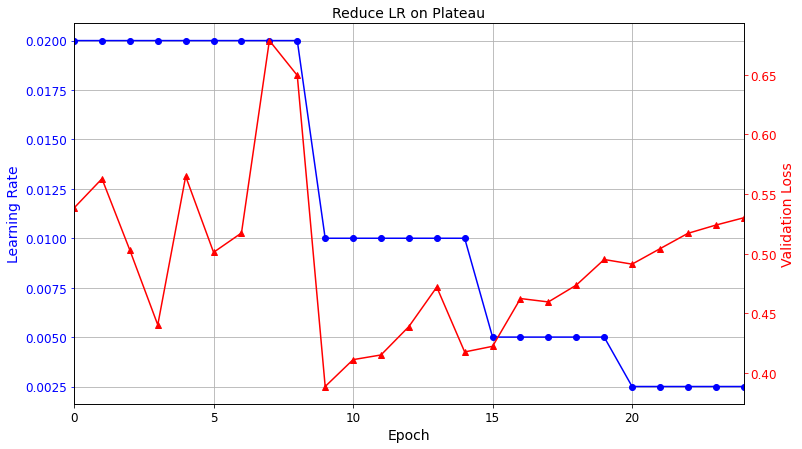

In [97]:
plt.figure(figsize=(12, 7))
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

## 1Cycle Scheduling

This approach is based on Leslie Smith's excellent body of research! Papers have been read a number of times and are saved on my local drive.

In [98]:
K = keras.backend

class Exponential_LR(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [99]:
# Method to find LR
def find_LR(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    
    K.set_value(model.optimizer.lr, min_rate)
    
    exp_lr = Exponential_LR(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, 
                        callbacks=[exp_lr])
    
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.figure(figsize=(12, 7))
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss");

In [100]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [101]:
batch_size = 128
rates, losses = find_LR(model, X_train_scaled, y_train, epochs=1, 
                        batch_size=batch_size)

Train on 55000 samples
55000/55000 [==============================] - 1s 25us/sample - loss: nan - accuracy: 0.3903


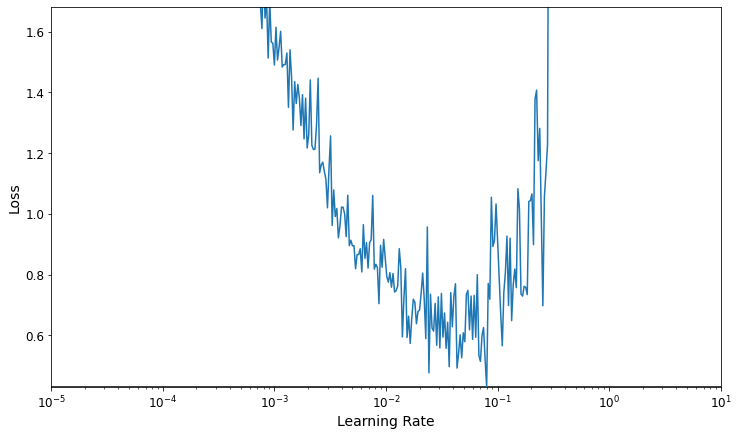

In [102]:
plot_lr_vs_loss(rates, losses)

In [103]:
# Creating a custom callback that modifies the LR at each iteration
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, 
                                     self.max_rate)
            
        elif self.iteration < (2 * self.half_iteration):
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, 
                                     self.max_rate, self.start_rate)
            
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
            
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [104]:
n_epochs = 30
one_cycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[one_cycle])

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 1s 24us/sample - loss: 0.6596 - accuracy: 0.7739 - val_loss: 0.4908 - val_accuracy: 0.8278
Epoch 2/30
55000/55000 [==============================] - 1s 21us/sample - loss: 0.4619 - accuracy: 0.8385 - val_loss: 0.4411 - val_accuracy: 0.8470
Epoch 3/30
55000/55000 [==============================] - 1s 23us/sample - loss: 0.4161 - accuracy: 0.8531 - val_loss: 0.4122 - val_accuracy: 0.8578
Epoch 4/30
55000/55000 [==============================] - 1s 21us/sample - loss: 0.3878 - accuracy: 0.8631 - val_loss: 0.3914 - val_accuracy: 0.8654
Epoch 5/30
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3676 - accuracy: 0.8696 - val_loss: 0.3767 - val_accuracy: 0.8662
Epoch 6/30
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3494 - accuracy: 0.8769 - val_loss: 0.3681 - val_accuracy: 0.8718
Epoch 7/30
55000/55000 [==============================] -

## Details on Regularization

### Avoiding Over-Fitting Using $l_{1}$ and $l_{2}$ Regularization

In addition to Batch-Norm, we can:

- Constrain a neural network's weights using L2 regularization.
- Use L1 regularization in case we want a sparse model.
- Generally, it is advisable to use the same regularization, activation and initialization in a model's layers. The code can be refactored using loops or creating wrappers for any callable, with some default arguments.

In [105]:
# Single layer with regularization 
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [106]:
# Regularization layers using sequential api
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])

In [107]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

n_epochs = 5

history = model.fit(X_train_scaled, y_train, epochs=n_epochs, 
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 4s 80us/sample - loss: 1.5895 - accuracy: 0.8103 - val_loss: 0.7553 - val_accuracy: 0.8096
Epoch 2/5
55000/55000 [==============================] - 4s 73us/sample - loss: 0.7184 - accuracy: 0.8264 - val_loss: 0.7178 - val_accuracy: 0.8222
Epoch 3/5
55000/55000 [==============================] - 4s 71us/sample - loss: 0.6979 - accuracy: 0.8349 - val_loss: 0.6824 - val_accuracy: 0.8412
Epoch 4/5
55000/55000 [==============================] - 4s 75us/sample - loss: 0.6910 - accuracy: 0.8384 - val_loss: 0.6700 - val_accuracy: 0.8526
Epoch 5/5
55000/55000 [==============================] - 4s 72us/sample - loss: 0.6908 - accuracy: 0.8369 - val_loss: 0.6755 - val_accuracy: 0.8428


**Since we usually apply the same regularizers, intialization strategies and activations, lets refactor the previous code segment to make it more Pythonic and less error prone.**

We will be using Python's _partial()_ function to create a thin wrapper for our callables. 

In [108]:
# Refactoring
from functools import partial

Reg_Dense = partial(keras.layers.Dense,
                    activation="elu",
                    kernel_initializer="he_normal",
                    kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    Reg_Dense(300),
    Reg_Dense(100),
    Reg_Dense(10, activation="softmax")
])

In [109]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

n_epochs = 5

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data = (X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 4s 81us/sample - loss: 1.6418 - accuracy: 0.8107 - val_loss: 0.7600 - val_accuracy: 0.8068
Epoch 2/5
55000/55000 [==============================] - 4s 72us/sample - loss: 0.7197 - accuracy: 0.8262 - val_loss: 0.7175 - val_accuracy: 0.8254
Epoch 3/5
55000/55000 [==============================] - 4s 74us/sample - loss: 0.6998 - accuracy: 0.8342 - val_loss: 0.6897 - val_accuracy: 0.8402
Epoch 4/5
55000/55000 [==============================] - 4s 74us/sample - loss: 0.6936 - accuracy: 0.8367 - val_loss: 0.6730 - val_accuracy: 0.8518
Epoch 5/5
55000/55000 [==============================] - 4s 73us/sample - loss: 0.6924 - accuracy: 0.8357 - val_loss: 0.6792 - val_accuracy: 0.8434


### Dropout

This extremely popular and effective technique basically applies the following algorithm:
- At every training step, every neuron - including inputs but **excluding outputs** has a probability _p_ of being temporarily dropped out i.e. being ignored during one training step and not during another training step.
- The hyperparameter _p_ is called the dropout rate. It is typically set between 10% and 50% -- 20% to 30% for RNNs -- 40% to 50% for CNNs.

This way, neurons trained with dropout cannot co-adapt with their neighbouring neurons; thereby maximizing their utility. This also leads them to be less sensitive to slight changes in the inputs.

**`Pro Tips`** 

- Dropout is usually applied to neurons in the top one to three layers (excluding the output layer).
- At p=50%, which results in a neuron being connected to twice as many input neurons on average during training, we will need to compensate by multiplying each neuron's input connection weights by 0.5 after training. More generally, we will need to multiply each input connection weight by the keep probability i.e. (1-p).
- We can also divide each input neuron with the keep probability during training.


In [118]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimzer="nadam",
              metrics=["accuracy"])

In [119]:
n_epochs = 5

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 4s 65us/sample - loss: 0.6233 - accuracy: 0.7970 - val_loss: 0.4160 - val_accuracy: 0.8584
Epoch 2/5
55000/55000 [==============================] - 3s 59us/sample - loss: 0.4654 - accuracy: 0.8391 - val_loss: 0.3992 - val_accuracy: 0.8618
Epoch 3/5
55000/55000 [==============================] - 3s 57us/sample - loss: 0.4271 - accuracy: 0.8527 - val_loss: 0.3863 - val_accuracy: 0.8724
Epoch 4/5
55000/55000 [==============================] - 3s 57us/sample - loss: 0.4103 - accuracy: 0.8585 - val_loss: 0.3538 - val_accuracy: 0.8836
Epoch 5/5
55000/55000 [==============================] - 3s 57us/sample - loss: 0.4036 - accuracy: 0.8650 - val_loss: 0.3851 - val_accuracy: 0.8818


### Alpha-Dropout

In the event we want to regularize a self-normalizing network based on SELU activations. This variant of dropout preserves the mean and standard deviation of its inputs.

In [122]:
tf.random.set_seed(42)
np.random.seed(42)

In [123]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(loss="sparse_categorical_crossentropy", optimzer=opt,
              metrics=["accuracy"])

In [124]:
n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 70us/sample - loss: 0.6495 - accuracy: 0.7690 - val_loss: 0.5390 - val_accuracy: 0.8542
Epoch 2/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.5097 - accuracy: 0.8157 - val_loss: 0.5788 - val_accuracy: 0.8508
Epoch 3/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4820 - accuracy: 0.8260 - val_loss: 0.5723 - val_accuracy: 0.8634
Epoch 4/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4691 - accuracy: 0.8299 - val_loss: 0.5813 - val_accuracy: 0.8712
Epoch 5/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4624 - accuracy: 0.8342 - val_loss: 0.5513 - val_accuracy: 0.8738
Epoch 6/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.4522 - accuracy: 0.8391 - val_loss: 0.6050 - val_accuracy: 0.8712
Epoch 7/25
55000/55000 [==============================] -

### Include Sections on Monte Carlo Dropout and Max Norm Regularization.